In [8]:
 from google.colab import drive
drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/My Drive/excelr/Day5/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np
import string, re
from string import digits
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [10]:
# !pip install keras

# Read Data

In [11]:
pwd

'/content'

In [12]:
def read_data():

    df = pd.read_csv("/content/sample_data/Copy of ArticlesMarch2018.csv")
   # df = df.drop(['comments'], axis = 1)
    return df

In [13]:
df=read_data()


In [14]:
df = read_data()
print(df.shape)
df.head(10)

(1385, 15)


,articleID,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,5a974697410cf7000162e8a4,By BINYAMIN APPELBAUM,article,"Virtual Coins, Real Resources","['Bitcoin (Currency)', 'Electric Light and Pow...",1,Business,1,01-03-2018 00:17,Economy,America has a productivity problem. One explan...,The New York Times,News,https://www.nytimes.com/2018/02/28/business/ec...,1207
1,5a974be7410cf7000162e8af,By HELENE COOPER and ERIC SCHMITT,article,U.S. Advances Military Plans for North Korea,"['United States Defense and Military Forces', ...",1,Washington,11,01-03-2018 00:40,Asia Pacific,The American military is looking at everything...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1215
2,5a9752a2410cf7000162e8ba,By THE EDITORIAL BOARD,article,Mr. Trump and the ‘Very Bad Judge’,"['Trump, Donald J', 'Curiel, Gonzalo P', 'Unit...",1,Editorial,26,01-03-2018 01:08,Unknown,Can you guess which man is the model public se...,The New York Times,Editorial,https://www.nytimes.com/2018/02/28/opinion/tru...,1043
3,5a975310410cf7000162e8bd,By JAVIER C. HERNÁNDEZ,article,"To Erase Dissent, China Bans Pooh Bear and ‘N’","['China', 'Xi Jinping', 'Term Limits (Politica...",1,Foreign,1,01-03-2018 01:10,Asia Pacific,Censors swung into action after Mr. Xi’s bid t...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1315
4,5a975406410cf7000162e8c3,"By JESSE DRUCKER, KATE KELLY and BEN PROTESS",article,Loans Flowed to Kushner Cos. After Visits to t...,"['Kushner, Jared', 'Kushner Cos', 'United Stat...",1,Business,1,01-03-2018 01:14,Unknown,"Apollo, the private equity firm, and Citigroup...",The New York Times,News,https://www.nytimes.com/2018/02/28/business/ja...,1566
5,5a975847410cf7000162e8cd,By ANA SWANSON,article,China Envoy Intends To Ease Trade Tensions,"['United States Politics and Government', 'Chi...",1,Business,11,01-03-2018 01:32,Politics,China has sent a top economic adviser to the U...,The New York Times,News,https://www.nytimes.com/2018/02/28/us/politics...,1349
6,5a975d54410cf7000162e8d2,By LINDA QIU,article,"President Trump’s Contradictory, and Sometimes...","['Gun Control', 'Trump, Donald J', 'Everytown ...",1,Washington,0,01-03-2018 01:54,Politics,The president mixed facts and falsehoods while...,The New York Times,News,https://www.nytimes.com/2018/02/28/us/politics...,630
7,5a976cb8410cf7000162e8ec,By DEB AMLEN,article,Classic Letter Puzzle,['Crossword Puzzles'],1,Games,0,01-03-2018 03:00,Unknown,Timothy Polin gives us choices.,The New York Times,News,https://www.nytimes.com/2018/02/28/crosswords/...,593
8,5a976d2b410cf7000162e8ee,By ADAM BAIDAWI,article,Silicon Valley Disruption In an Australian School,"['Lumineer Academy', 'Education (K-12)', 'For-...",1,Foreign,7,01-03-2018 03:01,Australia,"Susan Wu, a Silicon Valley entrepreneur, has o...",The New York Times,News,https://www.nytimes.com/2018/02/28/world/austr...,1278
9,5a977ac9410cf7000162e8fa,By SEWELL CHAN,article,‘The Assassination of Gianni Versace’ Episode ...,"['Television', 'The Assassination of Gianni Ve...",1,Culture,0,01-03-2018 04:00,Television,Rejected by both a sugar daddy and by the youn...,The New York Times,Review,https://www.nytimes.com/2018/02/28/arts/televi...,1251


# Preprocess

In [15]:
df.source=df['snippet']
df.target=df['headline']

In [16]:
def preprocess(df):
    # convert source and target text to Lowercase
    df.source = df.source.apply(lambda x: x.lower())
    df.target = df.target.apply(lambda x: x.lower())

    # creating a space between a word and the punctuation following it
    df.source = df.source.apply(lambda x: re.sub(r"([?.!,¿])", r" \1 ", x))
    df.target = df.target.apply(lambda x: re.sub(r"([?.!,¿])", r" \1 ", x))

    df.source = df.source.apply(lambda x: re.sub(r'[" "]+', " ", x))
    df.target = df.target.apply(lambda x: re.sub(r'[" "]+', " ", x))

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    df.source = df.source.apply(lambda x: re.sub(r"[^a-zA-Z?.!,¿]+", " ", x))
    df.target = df.target.apply(lambda x: re.sub(r"[^a-zA-Z?.!,¿]+", " ", x))

    # Remove digits from source and target sentences
    num_digits = str.maketrans('', '', digits)
    df.source = df.source.apply(lambda x: x.translate(num_digits))
    df.target = df.target.apply(lambda x: x.translate(num_digits))

    # Remove extra spaces
    df.source = df.source.apply(lambda x: x.strip())
    df.target = df.target.apply(lambda x: x.strip())
    df.source = df.source.apply(lambda x: re.sub(" +", " ", x))
    df.target = df.target.apply(lambda x: re.sub(" +", " ", x))

    # Add start and end tokens to target sequences
    df.target = df.target.apply(lambda x: 'START_ ' + x + ' _END')

    return df

In [17]:
df = preprocess(df)
df.head()

,articleID,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,5a974697410cf7000162e8a4,By BINYAMIN APPELBAUM,article,"Virtual Coins, Real Resources","['Bitcoin (Currency)', 'Electric Light and Pow...",1,Business,1,01-03-2018 00:17,Economy,America has a productivity problem. One explan...,america has a productivity problem . one expla...,News,https://www.nytimes.com/2018/02/28/business/ec...,1207
1,5a974be7410cf7000162e8af,By HELENE COOPER and ERIC SCHMITT,article,U.S. Advances Military Plans for North Korea,"['United States Defense and Military Forces', ...",1,Washington,11,01-03-2018 00:40,Asia Pacific,The American military is looking at everything...,the american military is looking at everything...,News,https://www.nytimes.com/2018/02/28/world/asia/...,1215
2,5a9752a2410cf7000162e8ba,By THE EDITORIAL BOARD,article,Mr. Trump and the ‘Very Bad Judge’,"['Trump, Donald J', 'Curiel, Gonzalo P', 'Unit...",1,Editorial,26,01-03-2018 01:08,Unknown,Can you guess which man is the model public se...,can you guess which man is the model public se...,Editorial,https://www.nytimes.com/2018/02/28/opinion/tru...,1043
3,5a975310410cf7000162e8bd,By JAVIER C. HERNÁNDEZ,article,"To Erase Dissent, China Bans Pooh Bear and ‘N’","['China', 'Xi Jinping', 'Term Limits (Politica...",1,Foreign,1,01-03-2018 01:10,Asia Pacific,Censors swung into action after Mr. Xi’s bid t...,censors swung into action after mr . xi s bid ...,News,https://www.nytimes.com/2018/02/28/world/asia/...,1315
4,5a975406410cf7000162e8c3,"By JESSE DRUCKER, KATE KELLY and BEN PROTESS",article,Loans Flowed to Kushner Cos. After Visits to t...,"['Kushner, Jared', 'Kushner Cos', 'United Stat...",1,Business,1,01-03-2018 01:14,Unknown,"Apollo, the private equity firm, and Citigroup...","apollo , the private equity firm , and citigro...",News,https://www.nytimes.com/2018/02/28/business/ja...,1566


# Tokenization

In [18]:
def tokenization(data, maxlen = 100):
    token = Tokenizer(lower=True, oov_token='oov')
    token.fit_on_texts(data)

    data_seq = token.texts_to_sequences(data)
    data_pad = pad_sequences(data_seq, maxlen=maxlen, padding='post')

    return token, data_pad

In [19]:
df['source']

,source
0,america has a productivity problem . one expla...
1,the american military is looking at everything...
2,can you guess which man is the model public se...
3,censors swung into action after mr . xi s bid ...
4,"apollo , the private equity firm , and citigro..."
...,...
1380,much of rural america will abandon the preside...
1381,we all want our children to have a better life...
1382,"mark peterson , the photographer who worked on..."
1383,if we learn anything from the recent controver...


In [20]:
df['target']=df['headline']

In [21]:
df.columns

Index(['articleID', 'byline', 'documentType', 'headline', 'keywords',
       'multimedia', 'newDesk', 'printPage', 'pubDate', 'sectionName',
       'snippet', 'source', 'typeOfMaterial', 'webURL', 'articleWordCount',
       'target'],
      dtype='object')

In [22]:
maxlen = 50
token_src, tensor_src = tokenization(df['source'], maxlen)
token_trg, tensor_trg = tokenization(df['target'], maxlen)

In [23]:
token_src

In [24]:
# prepare english tokenizer
eng_tokenizer =token_src
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = maxlen
print('Size of snippet Vocabulary : %d' % eng_vocab_size)

# prepare French tokenizer
fre_tokenizer = token_trg
fre_vocab_size = len(fre_tokenizer.word_index) + 1
fre_length = maxlen
print('Size of headline Vocabulary : %d' % fre_vocab_size)

Size of snippet Vocabulary : 6473
Size of headline Vocabulary : 3693


# Glove and Embedding Matrix

In [25]:
!wget "https://nlp.stanford.edu/data/glove.6B.zip"

--2025-05-03 10:18:50--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-03 10:18:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2025-05-03 10:21:29 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [26]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [27]:
# creating glove vectors
def get_glove_vector():
    glove_vectors = {}

    with open("glove.6B.100d.txt", "r", encoding="UTF-8") as glove:
        for line in glove:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:])
            glove_vectors[word] = vectors
    return glove_vectors

glove_vectors = get_glove_vector()
total_words = len(glove_vectors.keys())
total_words

400000

In [28]:
emb_dim = 100

# create word vector matrix with glove vectors
def create_word_vector_matrix(token, glove_vectors, vocab_size, emb_dim):
    word_vector_matrix = np.zeros((vocab_size, emb_dim))

    count = 0
    for word, index in token.word_index.items():
        vector = glove_vectors.get(word)
        if vector is not None:
            word_vector_matrix[index] = vector
        else:
            count += 1
    print(f"Vector not found for {count} words")
    return word_vector_matrix

In [29]:
emb_matrix_src = create_word_vector_matrix(token_src, glove_vectors, eng_vocab_size, emb_dim)
emb_matrix_trg = create_word_vector_matrix(token_trg, glove_vectors, fre_vocab_size, emb_dim)

Vector not found for 68 words
Vector not found for 323 words


# Model

In [30]:
fre_length

50

In [31]:


model = Sequential()
model.add(Embedding(eng_vocab_size, 100, input_length=eng_length, mask_zero=True, weights=[emb_matrix_src]))
model.add(LSTM(512))
model.add(RepeatVector(fre_length))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(fre_vocab_size, activation='softmax'))

rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',  metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       647,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,300 (2.47 MB)

 Trainable params: 647,300 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# !pip install keras==2.15.0

In [33]:
print(tensor_src.shape, tensor_trg.shape)

(1385, 50) (1385, 50)


In [34]:
# model_name = "sentiment_analysis_lstm_model.keras" # changed the extension to .keras

# modelcheckpoint = ModelCheckpoint(model_name,
#                                   monitor='val_loss',
#                                   mode='auto',
#                                   verbose=1,
#                                   save_best_only=True)

# lr_callback = ReduceLROnPlateau(min_lr=0.000001)

# callback_list = [modelcheckpoint, lr_callback]


# model = Sequential()
# model.add(Embedding(eng_vocab_size, 100, input_length=eng_length, mask_zero=True, weights=[emb_matrix_src]))
# model.add(LSTM(512))
# model.add(RepeatVector(fre_length))
# model.add(LSTM(512, return_sequences=True))
# model.add(Dense(fre_vocab_size, activation='softmax'))

# rms = optimizers.RMSprop(lr=0.001)
# model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',  metrics=["accuracy"])
# model.summary()

In [35]:
history = model.fit(tensor_src, tensor_trg, epochs=100, batch_size=32, validation_split=0.2, shuffle=True)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.7576 - loss: 2.7530 - val_accuracy: 0.8641 - val_loss: 1.1581
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8593 - loss: 1.2284 - val_accuracy: 0.8649 - val_loss: 1.1463
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8653 - loss: 1.1375 - val_accuracy: 0.8649 - val_loss: 1.1425
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8616 - loss: 1.1230 - val_accuracy: 0.8660 - val_loss: 1.1563
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8593 - loss: 1.1431 - val_accuracy: 0.8660 - val_loss: 1.1973
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8570 - loss: 1.1447 - val_accuracy: 0.8660 - val_loss: 1.1614
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8597 - loss: 1.1241 - val_accuracy: 0.8650 - val_loss: 1.1653
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8584 - loss: 1.1272 - val_accuracy: 0.

# Inference

In [36]:
reverse_word_index_src = {v: k for k, v in token_src.word_index.items()}
reverse_word_index_trg = {v: k for k, v in token_trg.word_index.items()}

In [37]:
tensor_src[50:51]

array([[   3,  149,  167, 1710,    7,    2,  739,  174, 1711,   13,  132,
         740,  590,  415,    6, 2866, 2867,    5,  432,  433,    5,   82,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [38]:
reverse_word_index_src[2],reverse_word_index_src[174]

('the', 'south')

In [39]:
res = model.predict(tensor_src[5:6])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


In [40]:
res = res.argmax(axis = 2)

In [41]:
def simplify(perdicted_tensor):
  string = ''
  for i in perdicted_tensor:
    word = reverse_word_index_trg.get(i)
    if word is not None:
      string += word + ' '
    # print(i, string)
  string = string.split(" ")[1:-2]
  ans = ''
  for j in string:
    ans += j + " "
  return ans[:-1]

In [42]:
res = simplify(list(res[0]))
res

'to in to to'

In [43]:
df['source'][50:51]

,source
50,a young public defender in the deep south stru...


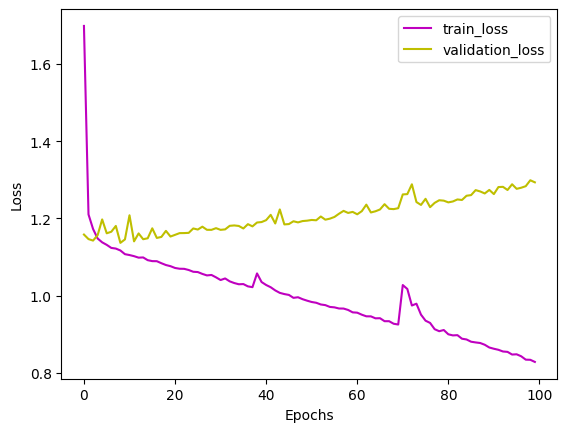

In [44]:
plt.plot(history.history['loss'], c='m')
plt.plot(history.history['val_loss'], c='y')
plt.legend(['train_loss', 'validation_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

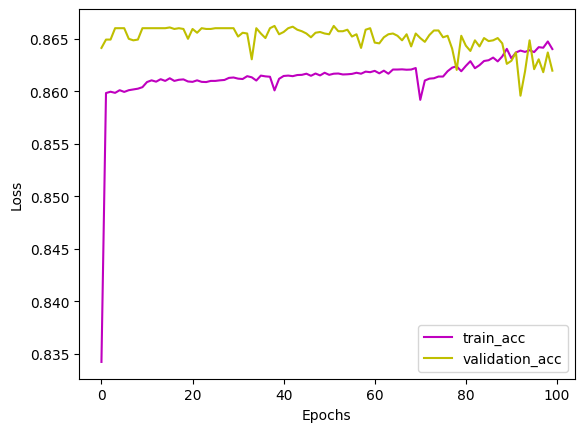

In [45]:
plt.plot(history.history['accuracy'], c='m')
plt.plot(history.history['val_accuracy'], c='y')
plt.legend(['train_acc', 'validation_acc'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()